<a href="https://colab.research.google.com/github/Yeswanth-EC/AI-model-using-PPO/blob/main/PPO_for_Bipedal_Walker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description:
          

*   I implemented the PPO (Proximal Policy Optimization) algorithm  to built a Reinforcement Learning agent using PyTorch to teach a 2D robot how to walk in the Gymnasium BipedalWalker-v3 environment because its unique "clipping" feature provides much better stability and smoother learning compared to other RL methods.
*   By using an Actor-Critic architecture in Google Colab, I was able to manage the complex physics and continuous joint torque required for movement.

*   After extensive training and hyperparameter tuning, the agent went from constantly face-planting to successfully navigating the terrain with a consistent score not excatly 300 but 290. This project was a fantastic way to see how AI can master balance and coordination through trial and error!




          
          

# Why PPO over other RL algorithm


*    **The Stability Factor**: In standard Policy Gradient methods, a single "bad" update can ruin the entire policy, causing the agent's performance to collapse. PPO introduces a Clipped Surrogate Objective.It calculates a ratio $r_t(\theta)$ between the new and old policy:
$$L^{CLIP}(\theta) = \hat{E}_t [\min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

This prevents the update from moving too far away from what the agent already knows, keeping the learning curve much smoother.


*   **Continuous Action Space**: Unlike DQN, which is built for discrete actions (like pressing a button), PPO handles Continuous Action Spaces beautifully. In BipedalWalker, the agent has to decide exactly how much force to apply to 4 different joints. PPO maps the state directly to a probability distribution (usually Gaussian) over those forces.

*   **Actor-Critic Architecture**: PPO typically uses an Actor-Critic setup:

      **The Actor**: Decides which action to take (the "brawn").

      **The Critic**: Predicts the reward the agent will get from a state           (the "brain" that evaluates the actor).






# PPO Implementation For Bipedal Walker

## Part 0 - Installing the packages, importing the libraries and Setting up the environment

### Installing Gymnasium

In [2]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 1 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (4,403 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubun

### Importing the libraries

In [3]:
import os
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.distributions import MultivariateNormal
from torch.autograd import Variable
from collections import deque, namedtuple
from torch.nn.modules.activation import Tanh

### Setting up the Environment

In [4]:
def make_env():
  return gym.make("BipedalWalker-v3")

num_envs = 8
envs = gym.vector.AsyncVectorEnv([make_env for _ in range(num_envs)])
state_size = envs.single_observation_space.shape[0]
action_size = envs.single_action_space.shape[0]

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [5]:
class ActorCritic(nn.Module):

  def __init__(self, state_size, action_size, seed = 42):
    super(ActorCritic, self).__init__() # Call the superclass constructor
    self.seed = torch.manual_seed(seed)
# Actor Network
    self.actor_layer = nn.Sequential(
        nn.Linear(state_size, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, action_size),
        nn.Tanh()  # tanh function maintain action value{-1 to +1}
    )
    self.log_std = nn.Parameter(torch.zeros(action_size))

# Critic Network
    self.critic_layer = nn.Sequential(
        nn.Linear(state_size, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512,1)
    )

  def forward(self, state):
    action_mean = self.actor_layer(state)
    value = self.critic_layer(state)
    action_std = torch.exp(self.log_std.expand_as(action_mean))
    covar_mat = torch.diag_embed(action_std)    # covariance matrix
    action_distribution = MultivariateNormal(action_mean, covar_mat)
    return action_distribution, value

### Initializing the hyperparameters

In [6]:
learning_rate = 3e-4
gamma = 0.99
gae_lambda = 0.95
ppo_epochs = 10
ppo_clip = 0.2
total_timesteps = 5000000
rollout_steps = 2048    # timesteps to update the parameters

### Memory Buffer

In [7]:
class Memory:
  def __init__(self):
    self.states = []
    self.actions = []
    self.values = []
    self.logprobs = []
    self.rewards = []
    self.masks = []

  def clear_memory(self):
    del self.states[:]
    del self.actions[:]
    del self.values[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.masks[:]



### Building the PPO Agent

In [8]:
class PPO_Agent:

  def __init__(self, state_size, action_size, learning_rate, ppo_epochs):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.policy = ActorCritic(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)

  def act(self, state):
    with torch.no_grad():
      dist, value = self.policy(state)
      action = dist.sample()
      action_logprob = dist.log_prob(action)
      entropy = dist.entropy().mean()
    # Return action as a tensor, not numpy array
    return action.detach(), action_logprob.detach(), value, entropy

  def update(self, old_states, old_actions, old_logprobs, advantages, returns, ppo_clip, ppo_epochs):
    old_states = old_states.to(self.device)
    old_actions = old_actions.to(self.device)
    old_logprobs = old_logprobs.to(self.device)
    advantages = advantages.to(self.device)
    returns = returns.to(self.device)

    # Optimizing policy for k epochs
    for _ in range(ppo_epochs):
      # Forward pass with current policy
      dists, values = self.policy(old_states)
      values = values.squeeze() # Ensure values is (batch_size,)
      logprobs = dists.log_prob(old_actions)
      dist_entropy = -logprobs.mean()

      # Finding the ratio(pi_theta / pi_theta_old)
      ratios = torch.exp(logprobs - old_logprobs.detach()) # old_logprobs is detached already

      # Finding Surrogate Loss
      surr1 = ratios * advantages
      surr2 = torch.clamp(ratios, 1 - ppo_clip, 1 + ppo_clip) * advantages

      actor_loss = -torch.min(surr1, surr2).mean()
      critic_loss = 0.5 * (returns - values).pow(2).mean()

      # total loss
      loss = actor_loss + critic_loss - 0.001 * dist_entropy

      # Taking a gradient step
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


### Generalized Advantage Estimation

In [9]:
def compute_gae(next_value, rewards, masks, values, gamma, gae_lambda, num_envs, rollout_steps, device):

  rewards = torch.cat(rewards).squeeze().to(device) # Shape (rollout_steps * num_envs,)
  values = torch.cat(values).squeeze().to(device)
  masks = torch.cat(masks).squeeze().to(device)

  advantages = torch.zeros_like(rewards).to(device)
  returns = torch.zeros_like(rewards).to(device)

  current_gae_per_env = torch.zeros(num_envs).to(device)
  current_next_value_per_env = next_value.clone()

  # Loop over the `rollout_steps` backward
  for i in reversed(range(rollout_steps)): # i is the timestep index within the rollout
      start_idx = i * num_envs
      end_idx = (i + 1) * num_envs

      rewards_i = rewards[start_idx:end_idx] # (num_envs,)
      values_i = values[start_idx:end_idx]
      masks_i = masks[start_idx:end_idx]

      # Calculate delta for each environment at timestep i
      delta = rewards_i + gamma * current_next_value_per_env * masks_i - values_i
      current_gae_per_env = delta + gamma * gae_lambda * masks_i * current_gae_per_env

      advantages[start_idx:end_idx] = current_gae_per_env
      returns[start_idx:end_idx] = current_gae_per_env + values_i # GAE return = GAE Advantage + V(s_t)

      current_next_value_per_env = values_i

  # Normalize advantages to stabilize training
  advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
  return advantages, returns


## Part 2 - Training the PPO Agent

In [ ]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

# Initialize logging variables
all_episode_rewards = []
all_episode_lengths = []
current_episode_rewards = np.zeros(num_envs)
current_episode_lengths = np.zeros(num_envs)
best_mean_reward = -np.inf

# Reset environments to get initial state
observation, info = envs.reset()
state = observation # state is the observation array

# Initialzing the PPO_Agent
ppo_agent = PPO_Agent(state_size, action_size, learning_rate, ppo_epochs )
memory = Memory()

# Load saved model if it exists to resume training
model_path = 'ppo_bipedal_walker.pth'
if os.path.exists(model_path):
    ppo_agent.policy.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Successfully loaded model from {model_path}. Resuming training.")
else:
    print("No saved model found. Starting training from scratch.")


timestep = 0
while timestep < total_timesteps:
  entropy = 0
  for _ in range(rollout_steps):
      state = torch.FloatTensor(state).to(device)
      action_tensor, log_prob, value, entro = ppo_agent.act(state)

      action_numpy = action_tensor.cpu().numpy()    # Converting action_tensor to numpy for env.step

      next_state, reward, terminated, truncated, _ = envs.step(action_numpy)
      done = terminated | truncated

      current_episode_rewards += reward
      current_episode_lengths += 1

      # For environments that just finished
      for i in range(num_envs):
          if done[i]:
              all_episode_rewards.append(current_episode_rewards[i])
              all_episode_lengths.append(current_episode_lengths[i])
              # Reset for the specific env that finished
              current_episode_rewards[i] = 0
              current_episode_lengths[i] = 0

      entropy += entro

      memory.values.append(value)
      memory.logprobs.append(log_prob)
      memory.rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
      memory.masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))   # Use done for masking
      memory.states.append(state)
      memory.actions.append(action_tensor)

      state = next_state # Update state for the next step

  # Get next_value for GAE calculation
  next_state_tensor = torch.FloatTensor(next_state).to(device)
  _, next_value = ppo_agent.policy(next_state_tensor)
  next_value = next_value.squeeze().detach() # Detach here as per PPO algorithm

  # Calculate advantages and returns using GAE
  advantages, returns = compute_gae(
      next_value,
      memory.rewards, memory.masks, memory.values,
      gamma, gae_lambda, num_envs, rollout_steps, device
  )

  # Prepare old policy data by concatenating lists from memory
  old_states = torch.cat(memory.states).to(device)
  old_actions = torch.cat(memory.actions).to(device)
  old_logprobs = torch.cat(memory.logprobs).detach().to(device) # Detach logprobs from the old policy

  # Network update phase
  ppo_agent.update(old_states, old_actions, old_logprobs, advantages, returns, ppo_clip, ppo_epochs)
  memory.clear_memory() # Call to clear_memory after update

  # Progress update
  timestep += rollout_steps * num_envs # Update total timestep count

  # Logging and saving
  if len(all_episode_rewards) > 0:
      mean_reward = np.mean(all_episode_rewards[-100:])
      mean_length = np.mean(all_episode_lengths[-100:])
      print(f"\rTimestep: {timestep}, Avg Episode Reward (last 100): {mean_reward:.2f}, Avg Episode Length (last 100): {mean_length:.2f}", end="")

      # Saving the model if a new best average reward is achieved
      if mean_reward > best_mean_reward:
          best_mean_reward = mean_reward
          model_path = 'ppo_bipedal_walker.pth'
          torch.save(ppo_agent.policy.state_dict(), model_path)
          print(f"\nModel saved at timestep {timestep} with new best average reward: {best_mean_reward:.2f}")

envs.close()

Successfully loaded model from ppo_bipedal_walker.pth. Resuming training.
Timestep: 16384, Avg Episode Reward (last 100): 108.57, Avg Episode Length (last 100): 940.69
Model saved at timestep 16384 with new best average reward: 108.57
Timestep: 32768, Avg Episode Reward (last 100): 154.63, Avg Episode Length (last 100): 1147.48
Model saved at timestep 32768 with new best average reward: 154.63
Timestep: 49152, Avg Episode Reward (last 100): 173.03, Avg Episode Length (last 100): 1213.75
Model saved at timestep 49152 with new best average reward: 173.03
Timestep: 65536, Avg Episode Reward (last 100): 176.21, Avg Episode Length (last 100): 1224.82
Model saved at timestep 65536 with new best average reward: 176.21
Timestep: 81920, Avg Episode Reward (last 100): 178.64, Avg Episode Length (last 100): 1250.15
Model saved at timestep 81920 with new best average reward: 178.64
Timestep: 98304, Avg Episode Reward (last 100): 184.30, Avg Episode Length (last 100): 1271.58
Model saved at timeste

## Part 3 - Evaluate Trained Agent



In [ ]:
import matplotlib.pyplot as plt

eval_env = gym.make("BipedalWalker-v3", render_mode="human")    # creating a new env for evaluation

# Instantiate a new ActorCritic policy and load the weights
eval_policy = ActorCritic(state_size, action_size).to(device)
eval_policy.load_state_dict(torch.load('ppo_bipedal_walker.pth', map_location=device))

eval_policy.eval()   # Set the evaluate policy network in evaluation mode

# Run the agent for a specified no.of evaluation episodes
num_eval_episodes = 5
eval_episode_rewards = []

print(f"\nStarting evaluation for {num_eval_episodes} episodes...")
for episode in range(num_eval_episodes):
    observation, info = eval_env.reset()
    state = observation
    episode_reward = 0
    done = False

    print(f"  Episode {episode + 1}/{num_eval_episodes}")

    # Loop until the episode terminates or truncates
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device) # unsqueeze for batch dimension
        with torch.no_grad():
            dist, _ = eval_policy(state_tensor)
            action = dist.sample()
        action_numpy = action.cpu().numpy().squeeze(0) # Convert to numpy and remove batch dim
        next_state, reward, terminated, truncated, _ = eval_env.step(action_numpy)
        done = terminated or truncated
        episode_reward += reward
        state = next_state

    eval_episode_rewards.append(episode_reward)  # Store the total reward for the episode
    print(f"    Episode finished with reward: {episode_reward:.2f}")

eval_env.close()

# 6. Calculate and print the average cumulative reward
if len(eval_episode_rewards) > 0:
    average_cumulative_reward = np.mean(eval_episode_rewards)
    print(f"\nAverage cumulative reward over {num_eval_episodes} evaluation episodes: {average_cumulative_reward:.2f}")
else:
    print("No evaluation episodes completed.")


Starting evaluation for 5 episodes...
  Episode 1/5
    Episode finished with reward: 279.64
  Episode 2/5
    Episode finished with reward: 276.87
  Episode 3/5
    Episode finished with reward: 276.10
  Episode 4/5
    Episode finished with reward: 276.39
  Episode 5/5
    Episode finished with reward: 277.29

Average cumulative reward over 5 evaluation episodes: 277.26


## Part 4 - Visualizing the results

In [10]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    total_reward = 0
    while not done:
        frame = env.render()
        frames.append(frame)
        # Convert state (numpy array) to torch tensor before passing to agent.act()
        state = torch.FloatTensor(state).to(agent.device)
        action_tensor, _, _, _ = agent.act(state) # agent.act returns (action, log_prob, value, entropy)
        # Convert action_tensor (torch tensor) to numpy array for env.step()
        action = action_tensor.cpu().numpy()
        state, reward, terminated, truncated, _ = env.step(action) # Use the numpy action
        total_reward += reward
        done = terminated or truncated
    env.close()
    print(f"Accumulated Reward: {total_reward:.2f}")
    imageio.mimsave('Trained.mp4', frames, fps=30)

show_video_of_model(ppo_agent, 'BipedalWalker-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()


Accumulated Reward: 290.27


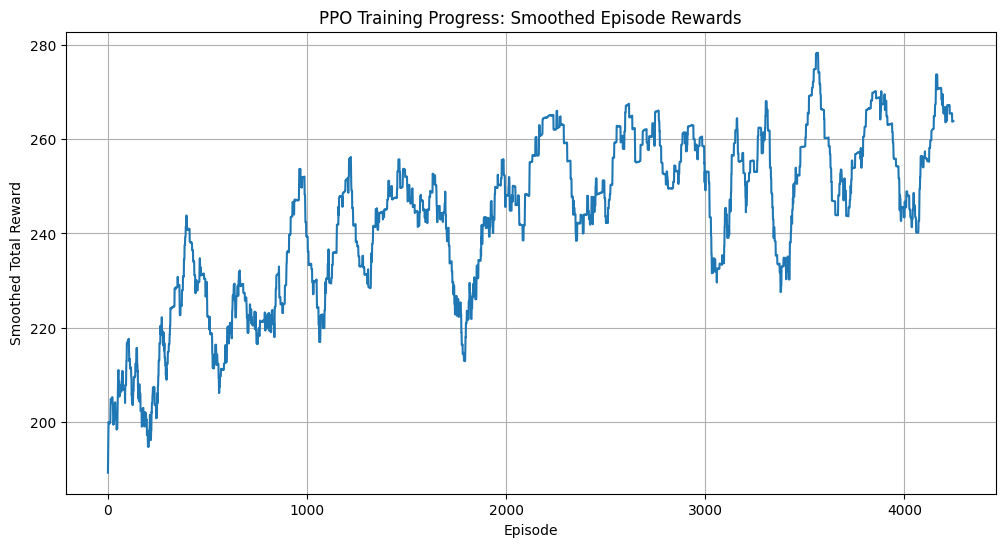

Plotting complete for smoothed rewards over a window of 100 episodes.


In [ ]:

# Helper function to smooth the rewards
def moving_average(data, window_size):
    if len(data) < window_size:
        return np.array(data)
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Set a window size for smoothing
window_size = 100
smoothed_rewards = moving_average(all_episode_rewards, window_size)

# Plotting the training progress
plt.figure(figsize=(12, 6))
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.title('PPO Training Progress: Smoothed Episode Rewards')
plt.grid(True)
plt.show()

print(f"Plotting complete for smoothed rewards over a window of {window_size} episodes.")
